In [38]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle

from model import ImageCaptionModel
from decoder import TransformerDecoder, RNNDecoder

## Exploring the Dataset

This assignment uses the Flickr 8k dataset! Let's go ahead and pull that in!

In [40]:
## Before this, download the dataset and run preprocessing.py as instructed. 
## This may take like 10 mins, but should only happen once so ok.
## https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

with open('../memes900k/data.p', 'rb') as data_file:
    data_dict = pickle.load(data_file)

# As mentioned in the handout, this assignment has 5 captions per image. This block of code 
# expands the image_feature lists to have 5 copies of each image to correspond to each of their captions 
feat_prep = lambda x: np.repeat(np.array(x).reshape(-1, 2048), 50, axis=0)
img_prep  = lambda x: np.repeat(x, 5, axis=0)

## Captions; preprocessed sentences with 20 window size
train_captions  = np.array(data_dict['train_captions']);            print('train_captions:  ', train_captions.shape)
test_captions   = np.array(data_dict['test_captions']);             print('test_captions:   ', test_captions.shape)

## 2048-D resnet embeddings of images.
train_img_feats = feat_prep(data_dict['train_image_features']);     print('\ntrain_img_feats: ', train_img_feats.shape)
test_img_feats  = feat_prep(data_dict['test_image_features']);      print('test_img_feats:  ', test_img_feats.shape)

## Small subset of actual images for visualization purposes. 
## These are just for the first 100 images of each (clones 5 times)
train_images    = img_prep(data_dict['train_images']);              print('\ntrain_images:    ', train_images.shape)
test_images     = img_prep(data_dict['test_images']);               print('test_images:     ', test_images.shape)

## Conversion dictionaries to go between word and label index
word2idx        = data_dict['word2idx']
idx2word        = data_dict['idx2word']

train_captions:   (12000, 21)
test_captions:    (3000, 21)

train_img_feats:  (12000, 2048)
test_img_feats:   (3000, 2048)

train_images:     (500, 299, 299, 3)
test_images:      (300, 299, 299, 3)


In [ ]:
from read_glove import get_glove_embedding

embeddings_index = get_glove_embedding("../GloVE/glove.6B.300d.txt")
num_tokens = len(word2idx)
embedding_dim = 300
hits = 0
misses = 0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "<start>" and "<end>" and "<unk>" and "<pad>"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        embedding_matrix[i] = tf.random.normal((embedding_dim, ))
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

In [43]:
embedding_matrix.shape

(10594, 300)

Since the images take up a lot of data, we only kept a sliver of the original images. Feel free to update the preprocessing to retain all of the images if you'd like. Below is a visualization of some of the data:

Caption 1: <start> ll just play for few minutes before going to bed sep aaaand it dawn <end> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had chance to win sep aaannd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> weekend just started sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> finally in relationship with the person you love sep aaaaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> ll only play for an hour sep aaaaannd it morning <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


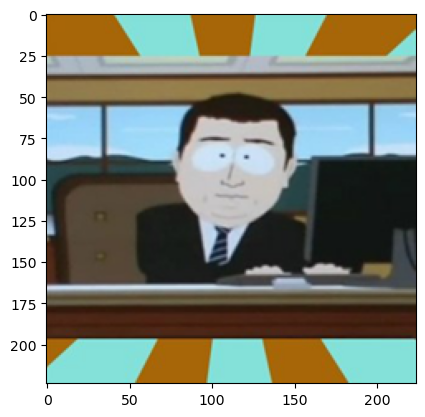

Caption 1: <start> poops reaches for toilet paper sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had good idea for meme sep aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> had my chance to hit it sep aaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> wild abra appears sep aaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> had the motivation to study sep aaaannndddd it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


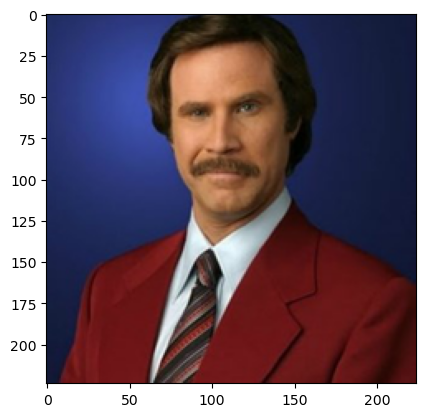

Caption 1: <start> just got paid sep and its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had really great dream last night sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> toronto has lead sep aaaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> just found out about flappy bird sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> here is obama with your tax payers money sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


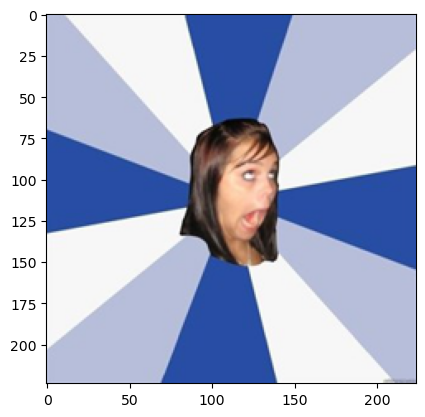

Caption 1: <start> ve got good idea sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> had some hope sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> october is here sep aaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> the mets have the lead going into the inning sep aaaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> just got my paycheck sep aaaand its gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


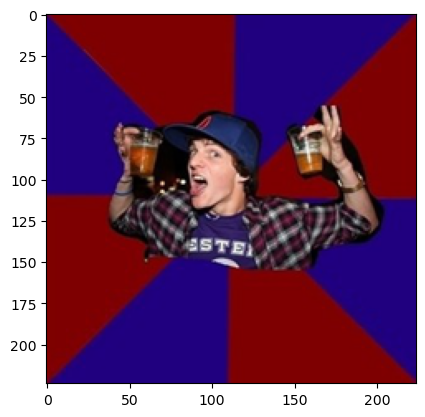

Caption 1: <start> ll just load save sep annddd surrounded by deathclaws <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 2: <start> moment ago felt compelled to do something nice for you sep and it gone <end> <pad> <pad> <pad> <pad> <pad>
Caption 3: <start> here some nice really warm weather sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 4: <start> you made another religious post sep aaaaaand you re gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Caption 5: <start> ll just look up my respect for you sep aaaaand it gone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


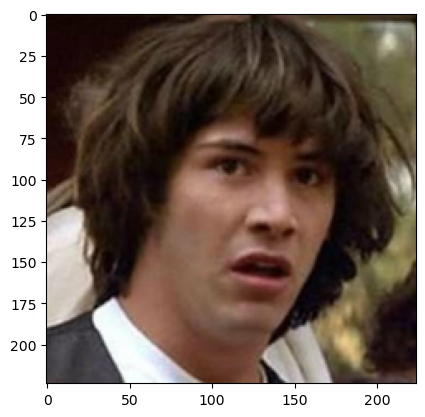

In [5]:
for i in range(5):
    for j in range(5):
        print(f'Caption {j+1}:', ' '.join([idx2word[idx] for idx in train_captions[i * 5 + j]]))
    plt.imshow(train_images[i * 5])
    plt.show()

### Running your RNN model

Depending on your use cases, you may choose to structure your model in a variety of ways. In contrast to previous assignments, this one is intended to mimic a lot of modern research-oriented repositories you might find in the wild. Specifically: **Instead of providing easy-to-use APIs for experimenters, they rigidify their implementation to make tests replicable.** Specifically, they may provide a command-line interface and define testing/training procedures which log results. 

(I mean, ideally you can make a flexible API and allow for both ease of extension and examples to demonstrate how your results were gathered, but sometimes researchers only have so much time...)

Once you have filled in the `model.py` components and the `RNNDecoder` of the `decoder.py` file, run this block to train your RNN model. As you can see, the hyperparamets default to the ones you use in `assignment.py`'s argparse specification, but feel free to change any of them to try to improve your model. 




In [47]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type rnn --task train --data ../memes900k/data.p --epochs 10 --chkpt_path ../rnn_model
## if using colab, you may need to do something like the following or might need to %cd into the directory of interest first...

2024-04-25 02:04:27.444309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Found 400000 word vectors.
2024-04-25 02:04:53.894251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Converted 9813 words (781 misses)
12000 12000
[Valid 30/30]	 loss=6.156	 acc: 0.192	 perp: 471.661
12000 12000
[Valid 30/30]	 loss=5.916	 acc: 0.212	 perp: 370.998
12000 12000
[Valid 30/30]	 loss=5.800	 acc: 0.225	 perp: 330.140
12000 12000
[Valid 30/30]	 loss=5.714	 acc: 0.236	 perp: 303

### Running your Transformer model

Once you have completed the `transformer.py` file, run this block to train your transformer based model. Note that running with the `both` task will both train, save, and test your model in one go.

In [30]:
## TODO: Increase epochs to a larger size when ready (maybe 2 or 3 would be enough?)
!python main.py --type transformer --task train --data ../memes900k/data.p --epochs 10 --lr 0.0005 --chkpt_path ../transform_model

2024-04-25 00:18:37.505443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 00:18:42.719724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
12000 12000
[Valid 30/30]	 loss=6.171	 acc: 0.191	 perp: 478.645
12000 12000
[Valid 30/30]	 loss=5.643	 acc: 0.230	 perp: 282.386
12000 12000
[Valid 30/30]	 loss=5.485	 acc: 0.254	 perp: 240.979
12000 12000
[Valid 30/30]	 loss=5.470	 acc: 0.255	 perp: 237.535
12000 12000
[Valid 30/30]	 loss=5.520	 acc: 0.260	 perp:

## Visualization

After training our Transformer model, you can visualize the self-attention layer to examine the behavior of your attention heads and see if any patterns emerge. 

To test out the components of the model interactively, you'll need to deconstruct selections of the model/runner code and get an instance of the model in an interactive context (aka inside the notebook). 



In [49]:
## Feel free to insert auto-reloads as necessary
from assignment import parse_args, load_model
from decoder import TransformerDecoder, RNNDecoder

## Pull your model into the notebook. This is heavily based off of assignment.py, 
## and feel free to reuse as much as you want. Your final project will probably 
## involve a lot of this investigative reverse-engineering based on what repos 
## you have to stumble upon.
## You're not in a notebook scenario, so use get_default_arguments and feel free to update it...

args = parse_args('--type rnn --task both --data ../memes900k/data.p'.split())

args.chkpt_path = '../transform_model'
tra_imcap = load_model(args)

args.chkpt_path = '../rnn_model'
rnn_imcap = load_model(args)

Model loaded from '../transform_model'


TypeError: RNNDecoder.__init__() missing 3 required positional arguments: 'vocab_size', 'hidden_size', and 'window_size'

In [ ]:
rnn_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_decoder (RNNDecoder)    multiple                  6484578   
                                                                 
Total params: 6,484,578
Trainable params: 6,484,578
Non-trainable params: 0
_________________________________________________________________


In [33]:
tra_imcap.summary()

Model: "image_caption_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_decoder_1 (Tran  multiple                 6548322   
 sformerDecoder)                                                 
                                                                 
Total params: 6,548,322
Trainable params: 6,548,322
Non-trainable params: 0
_________________________________________________________________


Now that we have our model, we need to be able to actually access the attention matrix that gets generated by out model. So that we can visualize it, right? Unfortunately for us, some convenience methods that allow you to make arbitrary model slices (i.e. the Functional API) are forfeit since our model is a subclass (in contrast to a sequential or functional). 

However, we can still dig into the model and force out way to computing the components we want. Our weights have been saved, after all...

The following block of code visualizes the decoder self-attention for a random images in the test dataset. 


Move your mouse over the words in the left hand column, and see how much attention your decoder self-attention layer pays to each word in the sentance as it encodes each word.

In [34]:
import tensorflow as tf
from vis_utils import plot_decoder_text_attention
import numpy as np

index = np.random.choice(np.array(list(range(0,300,5))))

caption    = test_captions[index][:-1]
image_feat = test_img_feats[index]
image      = test_images[index]

# print("Image number:", index)

# def get_attention(tra_imcap, image_feat, caption):
#     ## TODO: If you're implementing multi-headed attension, you may need to change 
#     ## some stuff to display to display all of the attention matrices.

#     ## Into impac decoder (NOTE: expand_dims only necessary for Transformer)
#     encoded_images = tra_imcap.decoder.image_embedding(tf.expand_dims(image_feat, 1))
#     # captions = tra_imcap.decoder.embedding(caption)
#     captions = tra_imcap.decoder.encoding(caption)
#     ## Into imcap TransformerBlock; get self-attention
#     AttentionHead = tra_imcap.decoder.decoder.self_atten
#     K = tf.tensordot(captions, AttentionHead.K, 1)
#     V = tf.tensordot(captions, AttentionHead.V, 1)
#     self_atten = AttentionHead.attn_mtx((K, V))
#     ## Into imcap TransformerBlock; get context self-attention
#     AttentionHead = tra_imcap.decoder.decoder.self_context_atten
#     K = tf.tensordot(captions, AttentionHead.K, 1)
#     V = tf.tensordot(captions, AttentionHead.V, 1)
#     self_context_atten = AttentionHead.attn_mtx((K, V))
#     return self_atten, self_context_atten


# def vis_attention(atten_mtx, image_features, caption, idx2word):
#     caption_words = [idx2word[idx] for idx in caption]
#     end_sentance_index = caption_words.index('<end>') if '<end>' in caption_words else 20
#     caption_words = caption_words[:end_sentance_index]
#     AttentionMatrix = atten_mtx[:, :end_sentance_index, :end_sentance_index]
#     AttentionMatrix = tf.reshape(AttentionMatrix, (1, 1, 1, end_sentance_index, end_sentance_index))
#     plot_decoder_text_attention(attention=AttentionMatrix, tokens=caption_words)

# self_atten, self_context_atten = get_attention(
#     tra_imcap, tf.expand_dims(image_feat, 0), tf.expand_dims(caption, 0)
# )

# print("self_atten")
# vis_attention(self_atten, image_feat, caption, idx2word)

# print("self_context_atten")
# vis_attention(self_context_atten, image_feat, caption, idx2word)

# plt.imshow(image)
# plt.show()

Image number: 290


AttributeError: 'MultiHeadedAttention' object has no attribute 'K'

### Caption Generation
Now that you have trained both of your models, it's time to use them to generate original captions for images in the testing set. First, the model is given the <start\> token and asked to generate probabilites for the next word in the sequence. The next token is chosen by sampling from that probability. This process repeats until the model generates the <end\> token, or the maximum sequence length is reached.

 



There is still one piece of this equation missing. The tokens are sampled from the probabilities your models generate, but your models were required to output logits, not probabilities. This is becasue this assignment, like many NLP models, uses temperature as a parameter in text generation. If the models sampled from  probabilies calculated by simply applying softmax to the logits, then the probability of the most likely word will usually be very high and the models will usually genrate the same, most probable caption every time. We use the temperature as a parameter to even out the probabilites so the model produces more 'creative' captions. This is done by dividing the logits by the temperature parameter before applying softmax. Higher temprature values will give a more creative captiong, while temprature values closer to 0 will be more greedy. Check out [this](https://lukesalamone.github.io/posts/what-is-temperature/) article for a demonstration and further explaination of temprature in NLP models.


The following blocks of code will generate a caption for the image currently selected for the attention visualization above. Try playing around with different temperature values and see how it changes the captions your models generate

In [35]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

temperature = .05
gen_caption_temperature(rnn_imcap, image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size)


'hey girl sep you can have to make my own own'

## Generating Sentences for Training Data 

C1: happy birthday peggy sep you magnificent woman
C2: so it your birthday sep ll alert the media
C3: happy birthday ben sep stay classy
C4: happy birthday jack sep you stay classy
C5: it friday sep going to do inappropriate things to you
RNN: happy birthday sep you re gonna have bad time
TRA: happy birthday sep stay classy


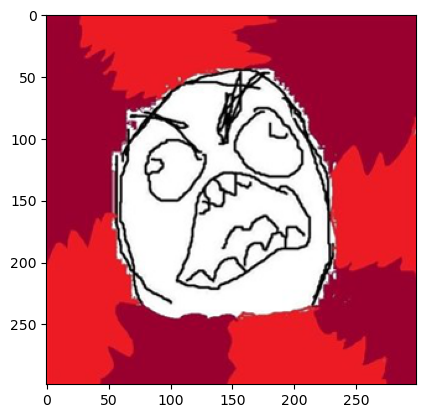

C1: hot married women sep you have no power here
C2: ve told you allah sep your people is just to stupid
C3: your scam sep has no power here
C4: steam sales sep you have no power here
C5: french kissing years old in an islamic country sep you have no power here
RNN: you have no sep so you re gonna have bad time
TRA: you have no power here sep you have no power here


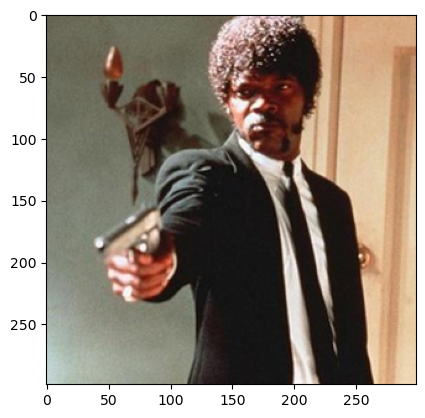

C1: liberals sep if it were legal to punch them that would be cool
C2: to all my haters sep fuck you
C3: used to hack on the kernel sep then took finger to the nose
C4: ruby python sep this in your phat ass
C5: lose source control license sep create git
RNN: emp sep emp
TRA: microsoft sep fuck you


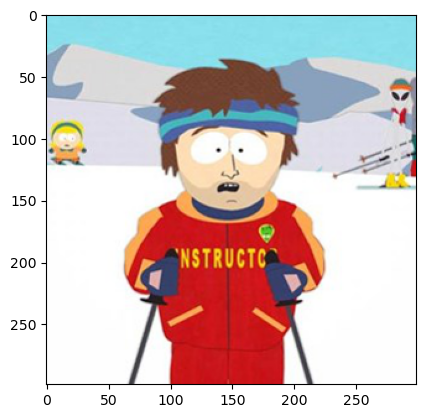

C1: has kid sep every single picture and status for the rest of her life is about having kid
C2: invites you to be her friend sep never speaks to you
C3: makes profile picture sep omg am such good person
C4: has few drinks sep mis spells facebook status on purpose
C5: likes god on facebook sep omg such good christian
RNN: you can haz sep with the same
TRA: omg sep stop kony


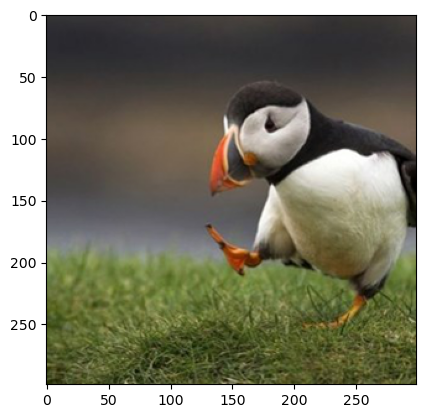

C1: what did you say sep hold on what did just say
C2: smoke weed for inspiration sep tons of good ideas no longer feel like writing
C3: lol sep just thought about possums
C4: do you listen to dubstep sep yes smoke weed
C5: goes to domino sep orders an piece mc whopper filet with no marshmallows
RNN: don have to be an eye sep with the same time to the same time
TRA: goes to quiznos what the cops sep we re just sits in front of class


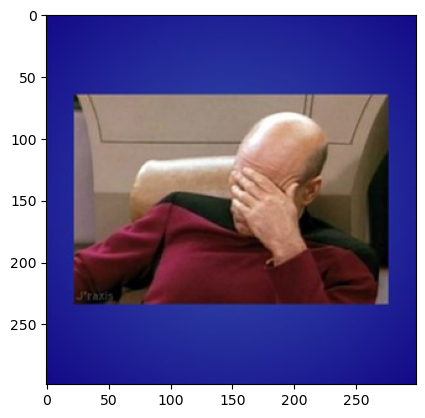

C1: what if anti virus companies sep invented viruses in the first place
C2: what if actually there is afterlife sep and our grandma is watching us masturbate
C3: if two lesbians are in relationship sep who makes the sandwiches
C4: what if deja vu means you actually died sep and are returning to your last checkpoint
C5: if the devil only punishes bad people sep doesn that make him good
RNN: what if told you sep you re gonna have bad time
TRA: what if the world is in the world if people are just sep and it was going to


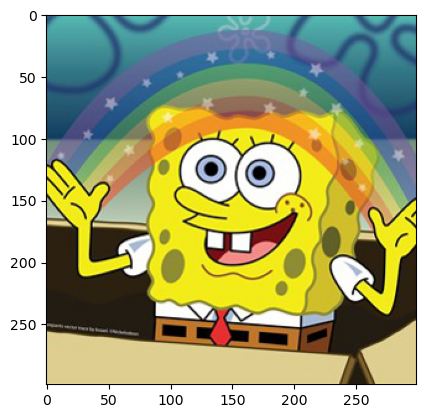

C1: happy birthday colette you beautiful classy lady sep you re kind of big deal
C2: happy tits mcgee sep mean kelly
C3: happy birthday mr walter sep stay shredded you lean mean fitness machine you
C4: don know if you know this but you re kind of big deal sep happy birthday kyle stay classy
C5: happy birthday dawg sep you stay classy
RNN: happy birthday sep you re gonna have bad time
TRA: happy birthday sep stay classy


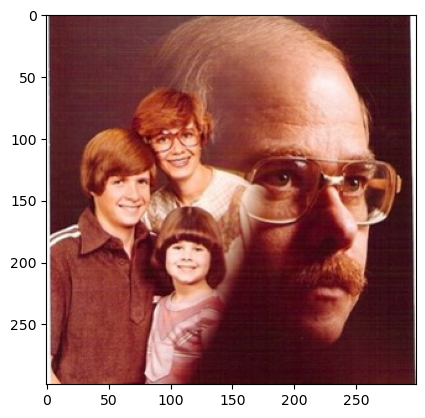

C1: don always make bad music sep oh wait yes do
C2: goes out with selena gomez sep still loses
C3: so gay hat even sep boys don loves me
C4: don always sing bad sep oh wait yes do
C5: fap fap fap sep fap for my boyfriend
RNN: you re gonna have to be an eye sep but it was an expert in the same
TRA: what is the best sep do is


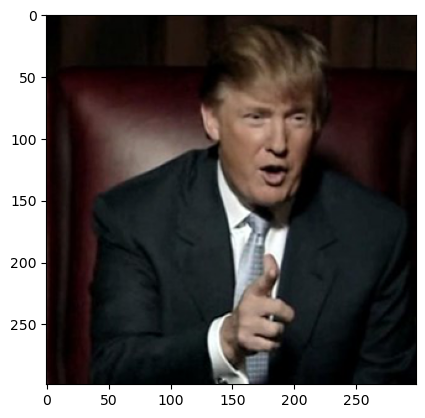

C1: like if you re kid sep born in
C2: omg sep and haven had sex
C3: loses argument with you on facebook sep deletes all your comments
C4: got boyfriend sep take pics with him now
C5: new years eve sep better remind everyone on facebook
RNN: can haz sep with the same
TRA: omg sep stop kony


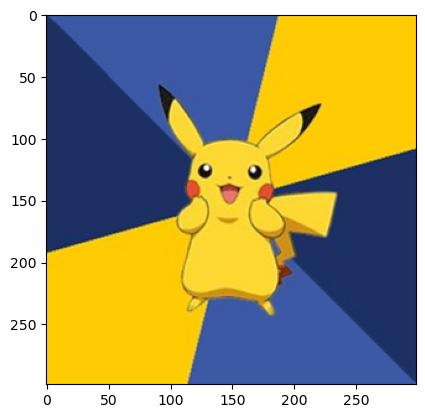

C1: has beats by dre sep still listens to kbps youtube rips
C2: guy sep cups
C3: gets wasted at party sep party had non alcoholic keg
C4: smokes weed sep doesn inhale
C5: takes picture with two beers sep becomes greatest douche ever
RNN: emp sep emp
TRA: dude sep drinks the dutchie


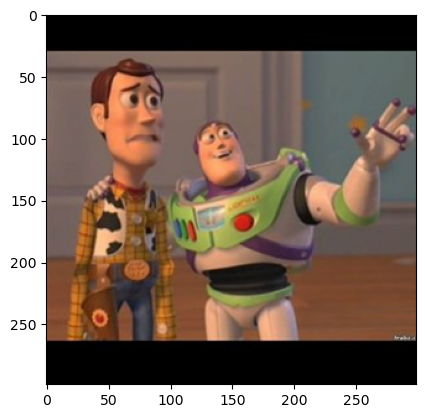

In [37]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 500, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = train_img_feats[i]
    curr_image      = train_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in train_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('RNN:', gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

### Trying out on things in testing set!

C1: roses are red violets are blue sep shut the fuck up or ill kill you
C2: any questions sep hope not
C3: doge isn funny sep emp
C4: if it were up to me sep both teams would lose
C5: don put my finger in pussies sep that animal abuse
RNN: you re gonna have my own sep so got that going for me which is nice
TRA: my face when sep when your face


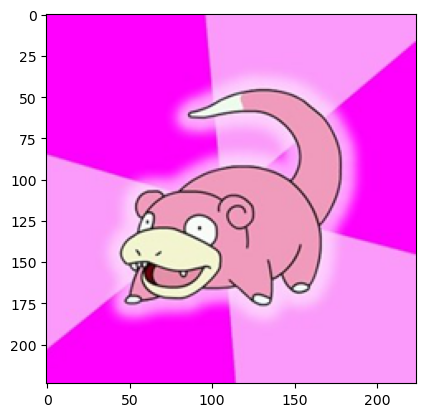

C1: don always laugh at memes sep but when do they are racist
C2: don always get up with time to spare sep but when do waste it online
C3: don <unk> fart sep but when do lean like this
C4: dont always finish my <unk> sep but when do
C5: dont always tell my girlfriend love her sep but when do it not on facebook
RNN: emp sep no one
TRA: hey girl sep we re gonna have bad time


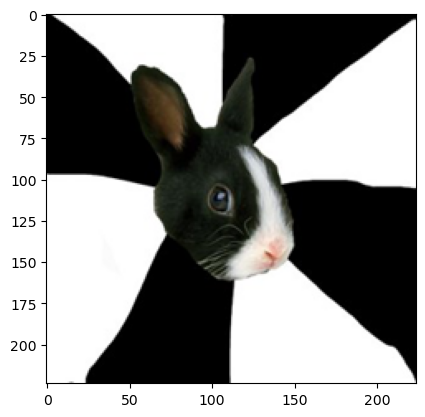

C1: don always lose my phone sep but when do it on silent mode
C2: don always watch twilight sep but when do don
C3: don always contradict myself sep but when do don
C4: don always fart sep but when do lean like this
C5: don always do homework sep but when do wait until the last minute
RNN: emp sep no one
TRA: hey girl sep we re gonna have bad time


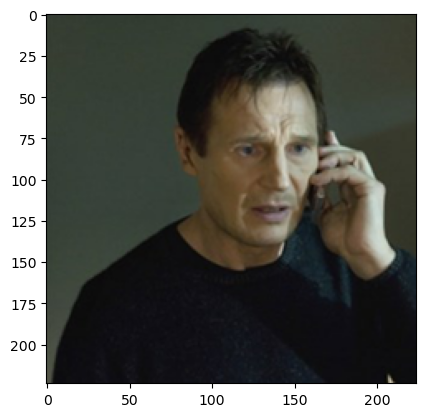

C1: dont always use the wrong meme sep challenge accepted
C2: don always call sep but when do ask the operator what she wearing
C3: don always see sep but when do it what you did there
C4: don always post on memegenerator sep but when do it because it working
C5: don always talk to <unk> state graduates sep but when do ask for large fries
RNN: emp sep no one
TRA: hey girl sep we ll have to make you clever


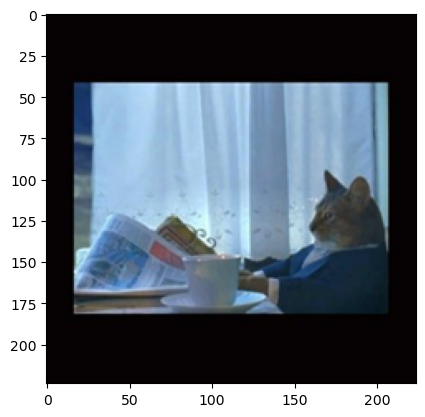

C1: will shit on everything sep you love
C2: new dress sep makes you look <unk>
C3: ok do you wanna talk <unk> sep no
C4: deal with it sep emp
C5: board games night saturday sep can wait
RNN: you re gonna have my own sep so got that going for me which is nice
TRA: my face when sep when your face


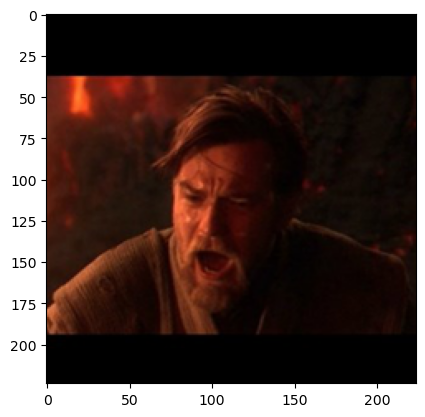

C1: please sep kony don take me
C2: what do mean there no santa sep emp
C3: please sep just shut up
C4: <unk> sep please just work
C5: luke sep pls join the dark side
RNN: you know sep you re gonna have bad time
TRA: sep guess


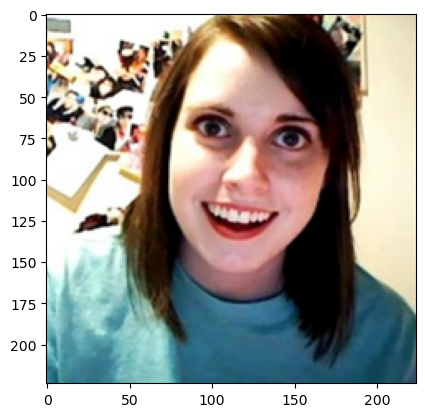

C1: posts fake status to get attention sep nobody cares
C2: why do my friends sep share spam on facebook
C3: but checked sep the disagree box
C4: call at and told her it was jake from state farm sep now she wants to talk to him
C5: not an <unk> sep ll make another spider man
RNN: don know what you sep that you know what you think it means what you think it means
TRA: what if told you sep that was born in


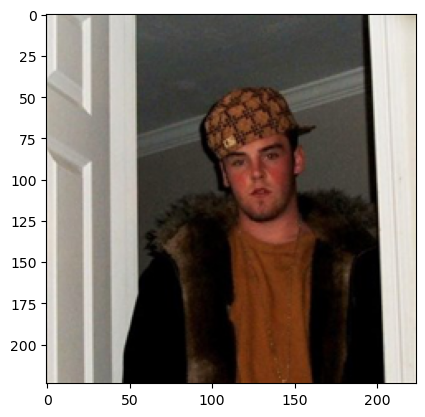

C1: don always open internet explorer sep but when do it to let it watch me use firefox
C2: don always text you sep but when do make sure it am and drunk as hell
C3: don always see my crush sep but when do look like shit
C4: emp sep but when do you can see my perfect hair
C5: don always go to mordor sep but when do simply walk in
RNN: emp sep no one
TRA: hey girl sep you re gonna have bad time


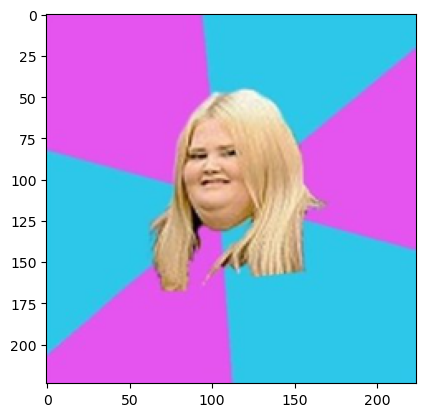

C1: when someone <unk> to sep take the last cookie
C2: <unk> sep want crew back
C3: can touch your boobs sep <unk>
C4: can have cookie sep please
C5: forever alone guy sep please stop being alone forever
RNN: you re gonna have bad sep but it
TRA: guess who sep can do


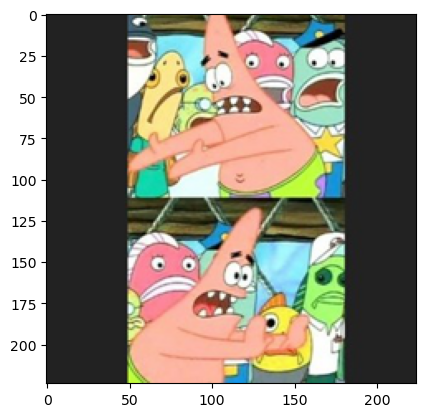

C1: you can be sep serious
C2: that dick so good my mouth is <unk> sep come let me kiss it
C3: eat pussy so hardcore sep that sometimes women <unk> with <unk>
C4: yeah listen just fine sep until the <unk> come off
C5: when your girl goes sep through your phone but you ve already deleted everything
RNN: you re gonna have bad time sep that paddlin
TRA: you think that word of the time sep you don have my name


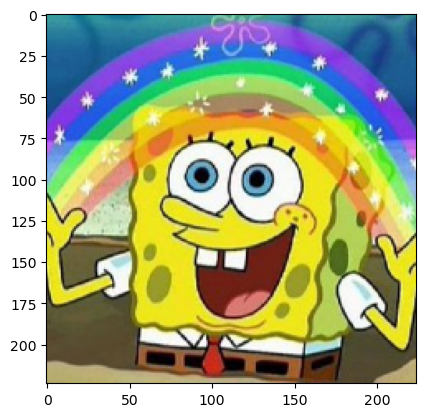

In [23]:
temperature = 0.05
indices = np.random.choice(np.array(list(range(0, 300, 5))), 10, replace=False)
for i in indices:
    curr_image_feat = test_img_feats[i]
    curr_image      = test_images[i]
    for j in range(5):  ## Display all of the captions trained on
        words = [idx2word[x] for x in test_captions[i+j][:-1] if idx2word[x] not in ('<pad>', '<start>', '<end>')]
        print(f'C{j+1}:', ' '.join(words))
    print('RNN:', gen_caption_temperature(rnn_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    print('TRA:', gen_caption_temperature(tra_imcap, curr_image_feat, word2idx, word2idx['<pad>'], temperature, args.window_size))
    plt.imshow(curr_image)
    plt.show()

# Conclusion!
Congrats! You have finished this assignment! Below, put down your favorite captions that your RNN and Transformer models both generated!  

In [ ]:
## TODO: fill in the ? and display the vis images with the generated caption below it

rnn_image_index = 42#?
rnn_caption = gen_caption_temperature(rnn_imcap, test_img_feats[rnn_image_index], word2idx, word2idx['<pad>'], temperature, args.window_size)

tra_image_index = 23#?
tra_caption = gen_caption_temperature(tra_imcap, test_img_feats[tra_image_index], word2idx, word2idx['<pad>'], temperature, args.window_size)

print(rnn_caption)
plt.imshow(test_images[rnn_image_index])
plt.show()

print(tra_caption)
plt.imshow(test_images[tra_image_index])
plt.show()